In [12]:
import sys
import os
import toml

import torch
import torcharrow
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe

import pandas as pd
import numpy as np
import scipy.optimize as SciOpt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from model.kcost import KCostModel
from data.kcost_dataset import EndureDataPipeGenerator
from model.tierlevelcost import TierLevelCost
from lsm.lsmtype import Policy
from jobs.train import TrainJob
import lsm.cost as CostFunc

In [2]:
config = Reader.read_config('../../endure.toml')

In [13]:
model_path = '/data/qcost-11-08'
config_model = Reader.read_config(os.path.join(model_path, 'endure.toml'))
ONE_MIB_BITS = 1024 * 1024 * 8
T_UPPER_LIM = config_model['lsm']['size_ratio']['max']
T_LOWER_LIM = config_model['lsm']['size_ratio']['min']
H_UPPER_LIM = config_model['lsm']['bits_per_elem']['max']
MAX_LEVELS = config_model['lsm']['max_levels']

dpg = EndureDataPipeGenerator(config_model)

In [14]:
tj = TrainJob(config_model)
model = tj._build_model()
model_data = torch.load(os.path.join(model_path, 'kcost_min.model'), map_location=torch.device('cpu'))
load_status = model.load_state_dict(model_data)
model.eval()
load_status

<All keys matched successfully>

In [15]:
cf = CostFunc.EndureQFixedCost(**config_model['system'])
def cost_func_objective(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    return cf.calc_cost(h, T, Q, z0, z1, q, w)

def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

def create_pairs(T, Q):
    t_frac = T - np.floor(T)
    q_frac = Q - np.floor(Q)
    norms = (l2_norm(1 - t_frac, 1 - q_frac),
             l2_norm(1 - t_frac, q_frac),
             l2_norm(t_frac, 1 - q_frac),
             l2_norm(t_frac, q_frac))
    normalizer = sum(norms)
    pairs = [(np.floor(T), np.floor(Q), norms[0] / normalizer),
             (np.floor(T), np.ceil(Q), norms[1] / normalizer),
             (np.ceil(T), np.floor(Q), norms[2] / normalizer),
             (np.ceil(T), np.ceil(Q), norms[3] / normalizer)]
    
    return pairs

def cost_func_learned_eval(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    row = [0, 0, 0, 0, h, z0, z1, q, w, T, Q]
    _, inputs = dpg._process_row(row)
    inputs = torch.from_numpy(inputs.reshape(1, -1))
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item() 
    return pred

def cost_func_learned(args, wl):
    h, T, Q = args[0], args[1], args[2]
    pairs = create_pairs(T, Q)
    val = 0
    for (t_prime, q_prime, frac) in pairs:
        val += frac * cost_func_learned_eval([h, t_prime, q_prime], wl)

    return val

In [16]:
def optimize(func=None, h_initial=9., T_initial=5., Q_initial=3., eps=1e-6, display=False):
    h_bounds = (0, H_UPPER_LIM)
    T_bounds = (T_LOWER_LIM, T_UPPER_LIM)
    Q_bounds = (T_LOWER_LIM - 1, T_UPPER_LIM - 1)

    bounds = [h_bounds, T_bounds, Q_bounds]
    min_cost = np.inf
    design = {}
    minimizer_kwargs = {
        'method' : 'SLSQP',
        'bounds' : bounds,
        'options': {'ftol': 1e-9, 'eps': eps, 'disp': display}}
    x0 = np.array([h_initial, T_initial, Q_initial])
    
    sol = SciOpt.minimize(
        fun=func,
        x0=x0,
        **minimizer_kwargs
    )
    return sol

In [17]:
analytical_sol = optimize(func=lambda x: cost_func_objective(x, config_model['workloads'][0]), eps=1e-2)
analytical_sol

     fun: 2.827294195864879
     jac: array([-1.32671651e-07, -1.54599622e-07,  1.07174896e-06])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([3.27812567, 6.10318895, 1.05539409])

In [26]:
learned_sol = optimize(func=lambda x: cost_func_learned(x, config_model['workloads'][0]), eps=1e-1)
learned_sol

     fun: 3.086445434757843
     jac: array([ 0.0090073 , -0.0075466 ,  1.03009248])
 message: 'Optimization terminated successfully'
    nfev: 68
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([3.75917529, 6.52529728, 1.        ])

In [28]:
p_args = [[analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],]
print(f'Analytical Output: {analytical_sol.x}')
for arg in p_args:
    print(f'Analytical Rounded: {arg}-> {cost_func_objective(arg, config_model["workloads"][0])}')
print(f'Learned Rounded: {learned_sol.x}-> {cost_func_objective(learned_sol.x, config_model["workloads"][0])}')

Analytical Output: [3.27812567 6.10318895 1.05539409]
Analytical Rounded: [3.2781256701489667, 6.0, 1.0]-> 2.830272435522601
Analytical Rounded: [3.2781256701489667, 6.0, 2.0]-> 3.3352966647852185
Analytical Rounded: [3.2781256701489667, 7.0, 1.0]-> 2.8545970966757404
Analytical Rounded: [3.2781256701489667, 7.0, 2.0]-> 3.208054069994117
Learned Rounded: [3.75917529 6.52529728 1.        ]-> 2.845424435442979


In [38]:
def gen_single_data(idx=0):
    workload = config_model['workloads'][idx]
    df = []
    h_fixed = 2
    t_fixed = 30
    q_fixed = 1
    for val in tqdm(np.arange(2, 49, 1)):
        x = [h_fixed, val, q_fixed]
        df.append({
            'x': val,
            'learned': cost_func_learned_eval(x, workload),
            'analytical': cost_func_objective(x, workload),
        })
    return pd.DataFrame(df)

idx = 7
df = gen_single_data(idx)

  0%|          | 0/47 [00:00<?, ?it/s]

{'id': 7, 'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49}

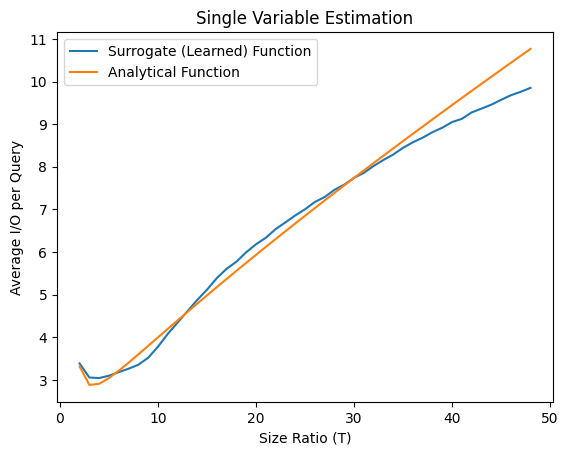

In [39]:
x = df['x']
y_learned = df['learned']
y_analytical = df['analytical']


fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
workload = config_model['workloads'][idx]
workload

In [23]:
def gen_hist_data(workload):
    df = []
    for h_p in tqdm(np.arange(0, H_UPPER_LIM, 0.5), leave=False):
        for T_p in np.arange(T_LOWER_LIM, T_UPPER_LIM, 1):
            for Q_p in range(T_LOWER_LIM - 1, T_p, 1):
                x = [h_p, T_p, Q_p]
                df.append({
                    'workload': workload,
                    'h': h_p,
                    'T': T_p,
                    'Q': Q_p,
                    'learned': cost_func_learned_eval(x, workload),
                    'analytical': cost_func_objective(x, workload),
                })
    return pd.DataFrame(df)

  0%|          | 0/19 [00:00<?, ?it/s]

{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, 'w': 0.01}

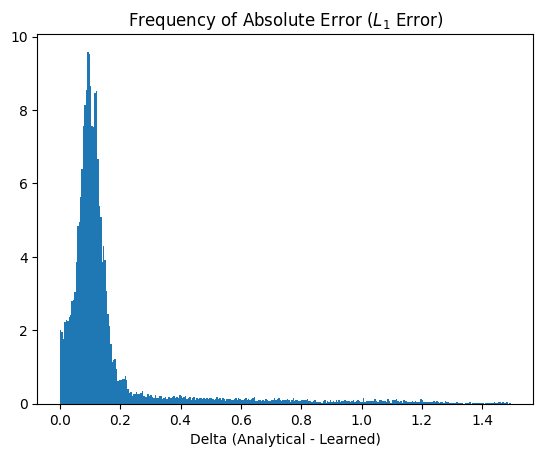

In [24]:
df = gen_hist_data(config_model['workloads'][1])

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('Frequency of Absolute Error ($L_1$ Error)')
config_model['workloads'][1]

In [25]:
dfs = []
for wl in tqdm(config_model['workloads']):
    dfs.append(gen_hist_data(wl))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
df = pd.concat(dfs)

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('All $w \in \mathcal{B}$ of Absolute Error ($L_1$ Error)')
None

In [ ]:
df.sort_values(by='delta')

In [ ]:
def generate_configurations():
    df = []
    for wl in tqdm(config_model['workloads']):
        z0, z1, q, w = (wl['z0'], wl['z1'], wl['q'], wl['w'])
        learn = optimize(func=lambda x: cost_func_learned(x, wl), eps=1e-3)
        hand = optimize(func=lambda x: cost_func_objective(x, wl), eps=1e-3)
        df.append({
            'id': wl['id'],
            'wl': wl,
            'learn': learn,
            'hand': hand,
            'delta': cost_func_objective(hand.x, wl) - cost_func_objective(learn.x, wl)
        })
    return pd.DataFrame(df)

df = generate_configurations()

In [ ]:
def sample_workload(dimensions: int=4) -> list:
    # See stackoverflow thread for why the simple solution is not uniform
    # https://stackoverflow.com/questions/8064629/random-numbers-that-add-to-100-matlab
    workload = list(np.random.rand(dimensions - 1)) + [0, 1]
    workload.sort()
    return [b - a for a, b in zip(workload, workload[1:])]

def gen_workload_heat(samples=10):
    df = []
    for _ in tqdm(range(samples)):
        z0, z1, q, w = sample_workload(dimensions=4)
        wl = {'z0': z0, 'z1': z1, 'q': q, 'w': w}
        learn = optimize(func=lambda x: cost_func_learned(x, wl), eps=1e-6, display=False)
        hand = optimize(func=lambda x: cost_func_objective(x, wl), eps=1e-6, display=False)
        cost_learn = cost_func_objective(learn.x, wl)
        cost_hand = cost_func_objective(hand.x, wl)
        df.append({
            'wl': wl,
            'learn': learn,
            'hand': hand,
            'cost_learn': cost_learn,
            'cost_hand': cost_hand,
        })
    return pd.DataFrame(df)

In [ ]:
df = gen_workload_heat(500)

In [ ]:
df['delta'] = (df['cost_hand'] - df['cost_learn'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('Frequency of Error: Positive is Better')